<a href="https://colab.research.google.com/github/phitonthel/YOG1-C_Final_Project/blob/master/Resnet_WITH_Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phitonthel","key":"d9ea2b50c6ed0d87faec6a6446db15dd"}'}

In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# List available datasets.
!kaggle datasets list



-rw-r--r-- 1 root root 66 Jun 22 09:53 kaggle.json
ref                                                             title                                                size  lastUpdated          downloadCount  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge               COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-06-19 00:27:19            887  
roche-data-science-coalition/uncover                            UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53           3525  
kwullum/fatal-police-shootings-in-the-us                        Fatal Police Shootings in the US                      1MB  2017-09-22 19:18:21          16151  
Cornell-University/arxiv                                        ArXiv Metadata                                        2GB  2020-05-06 23:18:35       

In [ ]:
# Download the Kaggle Dataset
!kaggle datasets download -d luisblanche/covidct

 94% 81.0M/85.8M [00:02<00:00, 37.6MB/s]
100% 85.8M/85.8M [00:02<00:00, 42.4MB/s]


In [ ]:
import zipfile
base_dir = '/content'
data_dir = os.path.join(base_dir, 'data')
local_zip = os.path.join(base_dir, 'covidct.zip')
zip_ref = zipfile.ZipFile(local_zip, 'r')
os.mkdir(data_dir)
zip_ref.extractall(data_dir)
zip_ref.close()

In [ ]:
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
os.mkdir(train_dir)
os.makedirs(os.path.join(test_dir, 'CT_COVID'))
os.mkdir(os.path.join(test_dir, 'CT_NonCOVID'))

In [ ]:
import random
import math
import shutil

train_portion = .90

def splitter(name):
  data_path = os.path.join(data_dir, name)
  temp = os.listdir(data_path)
  random.shuffle(temp)
  split = math.floor(len(temp) * train_portion)

  test_tmp = temp[split:]

  for i in test_tmp:
    shutil.move(os.path.join(data_path, i), os.path.join(test_dir, name, i))
  
  shutil.move(data_path, train_dir)

In [ ]:
splitter('CT_COVID')
splitter('CT_NonCOVID')

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range = 0.1,
    fill_mode = 'nearest'
    )
     
test_datagen = ImageDataGenerator(
    rescale=1./255
    )

train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size=(150,150),
	class_mode='binary',
  batch_size= 61
)

test_generator = test_datagen.flow_from_directory(
	test_dir,
	target_size=(150,150),
	class_mode='binary',
  batch_size=25
)

Found 671 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(150, 150, 3),
                                               include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
regularizer = tf.keras.regularizers.L1L2(
    l1=0.5, l2=0.5
)
for layer in base_model.layers:
  layer.trainable = False
  for attr in ['kernel_regularizer']:
    if hasattr(layer, attr):
      setattr(layer, attr, regularizer)

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
last_layer = base_model.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 2048)


In [ ]:
class AccCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > .9:
      self.model.stop_training = True

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(.2)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)           

model = tf.keras.Model(base_model.input, x) 

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
history = model.fit(train_generator, epochs=40, steps_per_epoch=3, validation_data = test_generator, verbose = 1, validation_steps=3,
                    # callbacks=[AccCallback()]
                    )

Epoch 1/40
3/3 [==============================] - 17s 6s/step - loss: 11.2136 - accuracy: 0.5137 - val_loss: 2.0428 - val_accuracy: 0.4667
Epoch 2/40
3/3 [==============================] - 16s 5s/step - loss: 2.4238 - accuracy: 0.5027 - val_loss: 0.7751 - val_accuracy: 0.5600
Epoch 3/40
3/3 [==============================] - 16s 5s/step - loss: 1.5475 - accuracy: 0.5137 - val_loss: 1.1102 - val_accuracy: 0.5867
Epoch 4/40
3/3 [==============================] - 16s 5s/step - loss: 1.0069 - accuracy: 0.5628 - val_loss: 1.2262 - val_accuracy: 0.4667
Epoch 5/40
3/3 [==============================] - 16s 5s/step - loss: 0.9522 - accuracy: 0.5246 - val_loss: 0.7564 - val_accuracy: 0.6133
Epoch 6/40
3/3 [==============================] - 16s 5s/step - loss: 0.8955 - accuracy: 0.5301 - val_loss: 0.9232 - val_accuracy: 0.4933
Epoch 7/40
3/3 [==============================] - 16s 5s/step - loss: 0.8822 - accuracy: 0.5082 - val_loss: 0.7027 - val_accuracy: 0.6267
Epoch 8/40
3/3 [=================

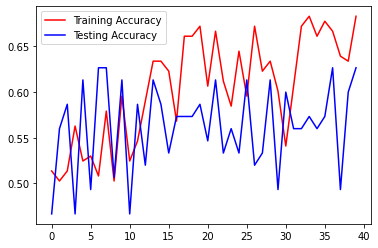

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Testing Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

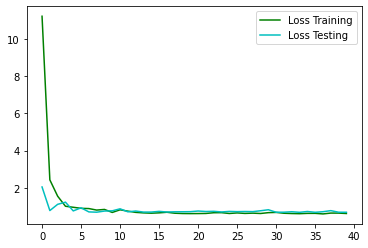

<Figure size 432x288 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, loss, 'g', label='Loss Training')
plt.plot(epochs, val_loss, 'c', label='Loss Testing')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model

saved_model_dir = 'saved_model/my_model'
model.save(saved_model_dir) 

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)


In [ ]:
model.export(export_dir='.')